In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [31]:
out = np.load('./voxel_prediction.npy')
faces = np.load('./faces.npy')
verts = np.load('./verts.npy')

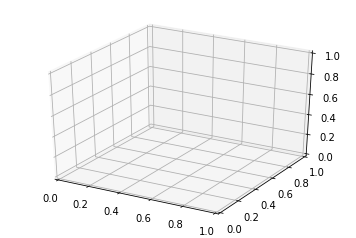

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

In [32]:
out.shape

(1, 32, 2, 32, 32)

ValueError: cannot reshape array of size 9984 into shape (32,32,32)

In [33]:
outmod = np.delete(out, 0,2)
outmod.shape


(1, 32, 1, 32, 32)

In [34]:
outmod = outmod.reshape(32,32,32,1)
outmod.shape

(32, 32, 32, 1)

In [35]:
from scipy.ndimage import zoom
resized = zoom(outmod, (2, 2, 2, 1))



In [36]:
resized.shape

(64, 64, 64, 1)

In [37]:
positions = np.where(resized[:,:,:,0] > 0.4)
resized[positions] = 1 
zeros = np.where(resized[:,:,:,0] < 0.4)
resized[zeros] = 0

In [38]:
    def plotFromVoxels(voxels,title=''):
        if len(voxels.shape)>3:
            x_d = voxels.shape[0]
            y_d = voxels.shape[1]
            z_d = voxels.shape[2]
            v = voxels[:,:,:,0]
            v = np.reshape(v,(x_d,y_d,z_d))
        else:
            v = voxels
        x, y, z = v.nonzero()
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x, y, z, zdir='z', c='red')
        #plt.show()
        plt.title(title)
        from matplotlib.pyplot import show
        show(block=False)

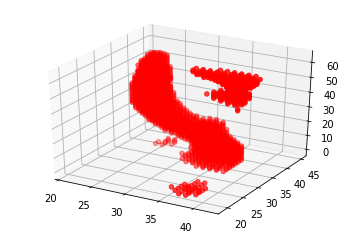

<function matplotlib.pyplot.show>

In [39]:
plotFromVoxels(resized)
plt.show

In [40]:
np.savez('./bench.npz', resized )

In [15]:
## The code below is to understand the data format for the input of 3D-RecGan++
def voxel2mesh(voxels, surface_view):
    cube_verts = [[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0],
                  [1, 1, 1]]  # 8 points

    cube_faces = [[0, 1, 2], [1, 3, 2], [2, 3, 6], [3, 7, 6], [0, 2, 6], [0, 6, 4], [0, 5, 1],
                  [0, 4, 5], [6, 7, 5], [6, 5, 4], [1, 7, 3], [1, 5, 7]]  # 12 face

    cube_verts = np.array(cube_verts)
    cube_faces = np.array(cube_faces) + 1

    scale = 0.01
    cube_dist_scale = 1.1
    verts = []
    faces = []
    curr_vert = 0

    positions = np.where(voxels > 0.3)
    voxels[positions] = 1
    for i, j, k in zip(*positions):
        # identifies if current voxel has an exposed face
        if not surface_view or np.sum(voxels[i-1:i+2, j-1:j+2, k-1:k+2]) < 27:
            verts.extend(scale * (cube_verts + cube_dist_scale * np.array([[i, j, k]])))
            faces.extend(cube_faces + curr_vert)
            curr_vert += len(cube_verts)

    return np.array(verts), np.array(faces)


def write_obj(filename, verts, faces):
    """ write the verts and faces on file."""
    with open(filename, 'w') as f:
        # write vertices
        f.write('g\n# %d vertex\n' % len(verts))
        for vert in verts:
            f.write('v %f %f %f\n' % tuple(vert))

        # write faces
        f.write('# %d faces\n' % len(faces))
        for face in faces:
            f.write('f %d %d %d\n' % tuple(face))


def voxel2obj(filename, pred, surface_view = True):
    verts, faces = voxel2mesh(pred, surface_view)
    write_obj(filename, verts, faces)
    return  verts, faces



In [16]:
voxel2obj('test_mesh.obj', resized)

ValueError: too many values to unpack (expected 3)